In [1]:
pip install imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pyimagej

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
import os
from fastai.vision.all import *
from nbdev.showdoc import *
import fastbook
fastbook.setup_book()
import random
from fastai.vision.augment import aug_transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from fastai.data.load import DataLoader
from imblearn.over_sampling import RandomOverSampler
import cv2
import imagej
from torchvision.models import vgg16
import torch.nn as nn



2024-06-17 13:49:38.126190: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 13:49:39.332457: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 13:49:40.609218: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
print("tensorflow version:", tf.__version__)
print("fastai version:", fastai.__version__)
print("nbdev.showdoc version:", show_doc.__module__.split('.')[1])
print("fastbook version:", fastbook.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("scikit-learn version:", sklearn.__version__)
print("seaborn version:", sns.__version__)
print("imbalanced-learn version:", imblearn.__version__)
print("cv2 version:", cv2.__version__)
print("imagej version:", imagej.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", vgg16.__module__.split('.')[1])

In [4]:
bac_minus_folder = 'NEGATIVOS'
bac_plus_folder = 'POSITIVOS'

bac_minus_paths = get_image_files(bac_minus_folder)
bac_plus_paths = get_image_files(bac_plus_folder)

bac_minus_labels = [0] * len(bac_minus_paths)
bac_plus_labels = [1] * len(bac_plus_paths)

all_paths = bac_minus_paths + bac_plus_paths
all_labels = bac_minus_labels + bac_plus_labels

df = pd.DataFrame({'image_path': all_paths, 'label': all_labels})

ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
oversampled_paths, oversampled_labels = ros.fit_resample(df[['image_path']], df['label'])

oversampled_df = pd.DataFrame({'image_path': oversampled_paths['image_path'], 'label': oversampled_labels})

train_val_df, test_df = train_test_split(
    oversampled_df, test_size=0.2, random_state=42, stratify=oversampled_df['label']
)

train_df, valid_df = train_test_split(
    train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['label']
)  

In [5]:
print(f"Total samples: {len(oversampled_df)}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")
print(f"Test samples: {len(test_df)}")

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('image_path'),
    get_y=ColReader('label'),
    item_tfms=Resize(256),
    batch_tfms=aug_transforms(flip_vert=False, do_flip=False)  # Ejemplo de augmentaciones
)



Total samples: 8834
Training samples: 5653
Validation samples: 1414
Test samples: 1767


In [6]:
dls = dblock.dataloaders(train_df, valid_df=valid_df, bs=8)

In [8]:
test_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('image_path'),
    get_y=ColReader('label'),
    item_tfms=Resize(512)
)


test_dl = dblock.dataloaders(test_df)

In [9]:
learn = cnn_learner(dls, models.vgg16_bn, metrics=[accuracy, Precision(), Recall(), F1Score()])


/data/home/alopezortiz/fastai-master/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [10]:
learn.fine_tune(15)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.687322,0.712835,0.769912,0.743842,0.813285,0.777015,03:51


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.511797,0.352655,0.839823,0.778107,0.944345,0.853204,04:09
1,0.510139,0.387996,0.834513,0.765805,0.956912,0.850758,04:07
2,0.457007,0.394298,0.836283,0.771930,0.947935,0.850927,04:13
3,0.462603,0.435512,0.837168,0.780451,0.931777,0.849427,04:15
4,0.419136,0.321364,0.860177,0.800905,0.953321,0.870492,04:09
5,0.378447,0.338723,0.856637,0.784173,0.978456,0.870607,04:12
6,0.302486,0.235600,0.913274,0.896373,0.931777,0.913732,04:16
7,0.201444,0.202015,0.931858,0.889610,0.983842,0.934356,04:16
8,0.201398,0.146972,0.957522,0.927731,0.991023,0.958333,04:13
9,0.155020,0.185333,0.925664,0.872441,0.994614,0.929530,04:17


In [ ]:
train_losses = [x[0] for x in learn.recorder.values]
valid_losses = [x[1] for x in learn.recorder.values]
accuracies = [x[2] for x in learn.recorder.values]
precision_score = [x[3] for x in learn.recorder.values]
recall_score = [x[4] for x in learn.recorder.values]
f1_score = [x[5] for x in learn.recorder.values]

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'r', label='Train Loss')
plt.plot(epochs, valid_losses, 'b', label='Valid Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, accuracies, 'b', label='Accuracy')
plt.plot(epochs, precision_score, 'g', label='Precision')
plt.plot(epochs, recall_score, 'm', label='Recall')
plt.plot(epochs, f1_score, 'k', label='F1-score')
plt.title('Accuracy, Precision, Recall and F1-score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

In [ ]:
accuracies_max = max(accuracies)
precision_score_max = max(precision_score)
recall_score_max = max(recall_score)
f1_score_max = max(f1_score)

accuracies_avg = np.mean(accuracies)
precision_score_avg = np.mean(precision_score)
recall_score_avg = np.mean(recall_score)
f1_score_avg = np.mean(f1_score)

print(f'Max accuracy: {accuracies_max}')
print(f'Max precision score: {precision_score_max}')
print(f'Max recall score: {recall_score_max}')
print(f'Max f1 score: {f1_score_max}')

print(f'Average accuracy: {accuracies_avg}')
print(f'Average precision score: {precision_score_avg}')
print(f'Average precision score: {recall_score_avg}')
print(f'Average precision score: {f1_score_avg}')

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

preds, targs = learn.get_preds()
probs = preds[:, 1]
fpr, tpr, _ = roc_curve(targs, probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label='ROC curve (area = %f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import matplotlib.pyplot as plt


cm = confusion_matrix(targs, preds.argmax(dim=1))

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dls.vocab, yticklabels=dls.vocab)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
modelo = learn.export('oversampling_vgg.pkl')

In [12]:
modelo = load_learner('oversampling_vgg.pkl')


In [13]:
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('L')
    img = np.array(img)
    img = np.stack([img, img, img], axis=0)
    img = np.transpose(img, (1, 2, 0))
    img = PILImage.create(img)
    return img

In [15]:
modelo.model.eval()

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [22]:
test_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('image_path'),
    get_y=ColReader('label'),
    item_tfms=Resize(256),
    batch_tfms=None
)

test_dls = test_dblock.dataloaders(test_df, bs=8)

In [23]:
test_dl = dls.test_dl(test_df)

In [24]:
test_dl

In [25]:
preds, targs = modelo.get_preds(dl=test_dl)
pred_labels = preds.argmax(dim=1)


In [26]:
def visualize_predictions(test_df, pred_labels, model):
    fig, axes = plt.subplots(4, 5, figsize=(20, 16))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        img_path = test_df.iloc[i]['image_path']
        img = PILImage.create(img_path)
        ax.imshow(img)
        true_label = test_df.iloc[i]['label']
        pred_label = pred_labels[i]
        ax.set_title(f'True: {model.dls.vocab[true_label]}, Predicted: {model.dls.vocab[pred_label]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

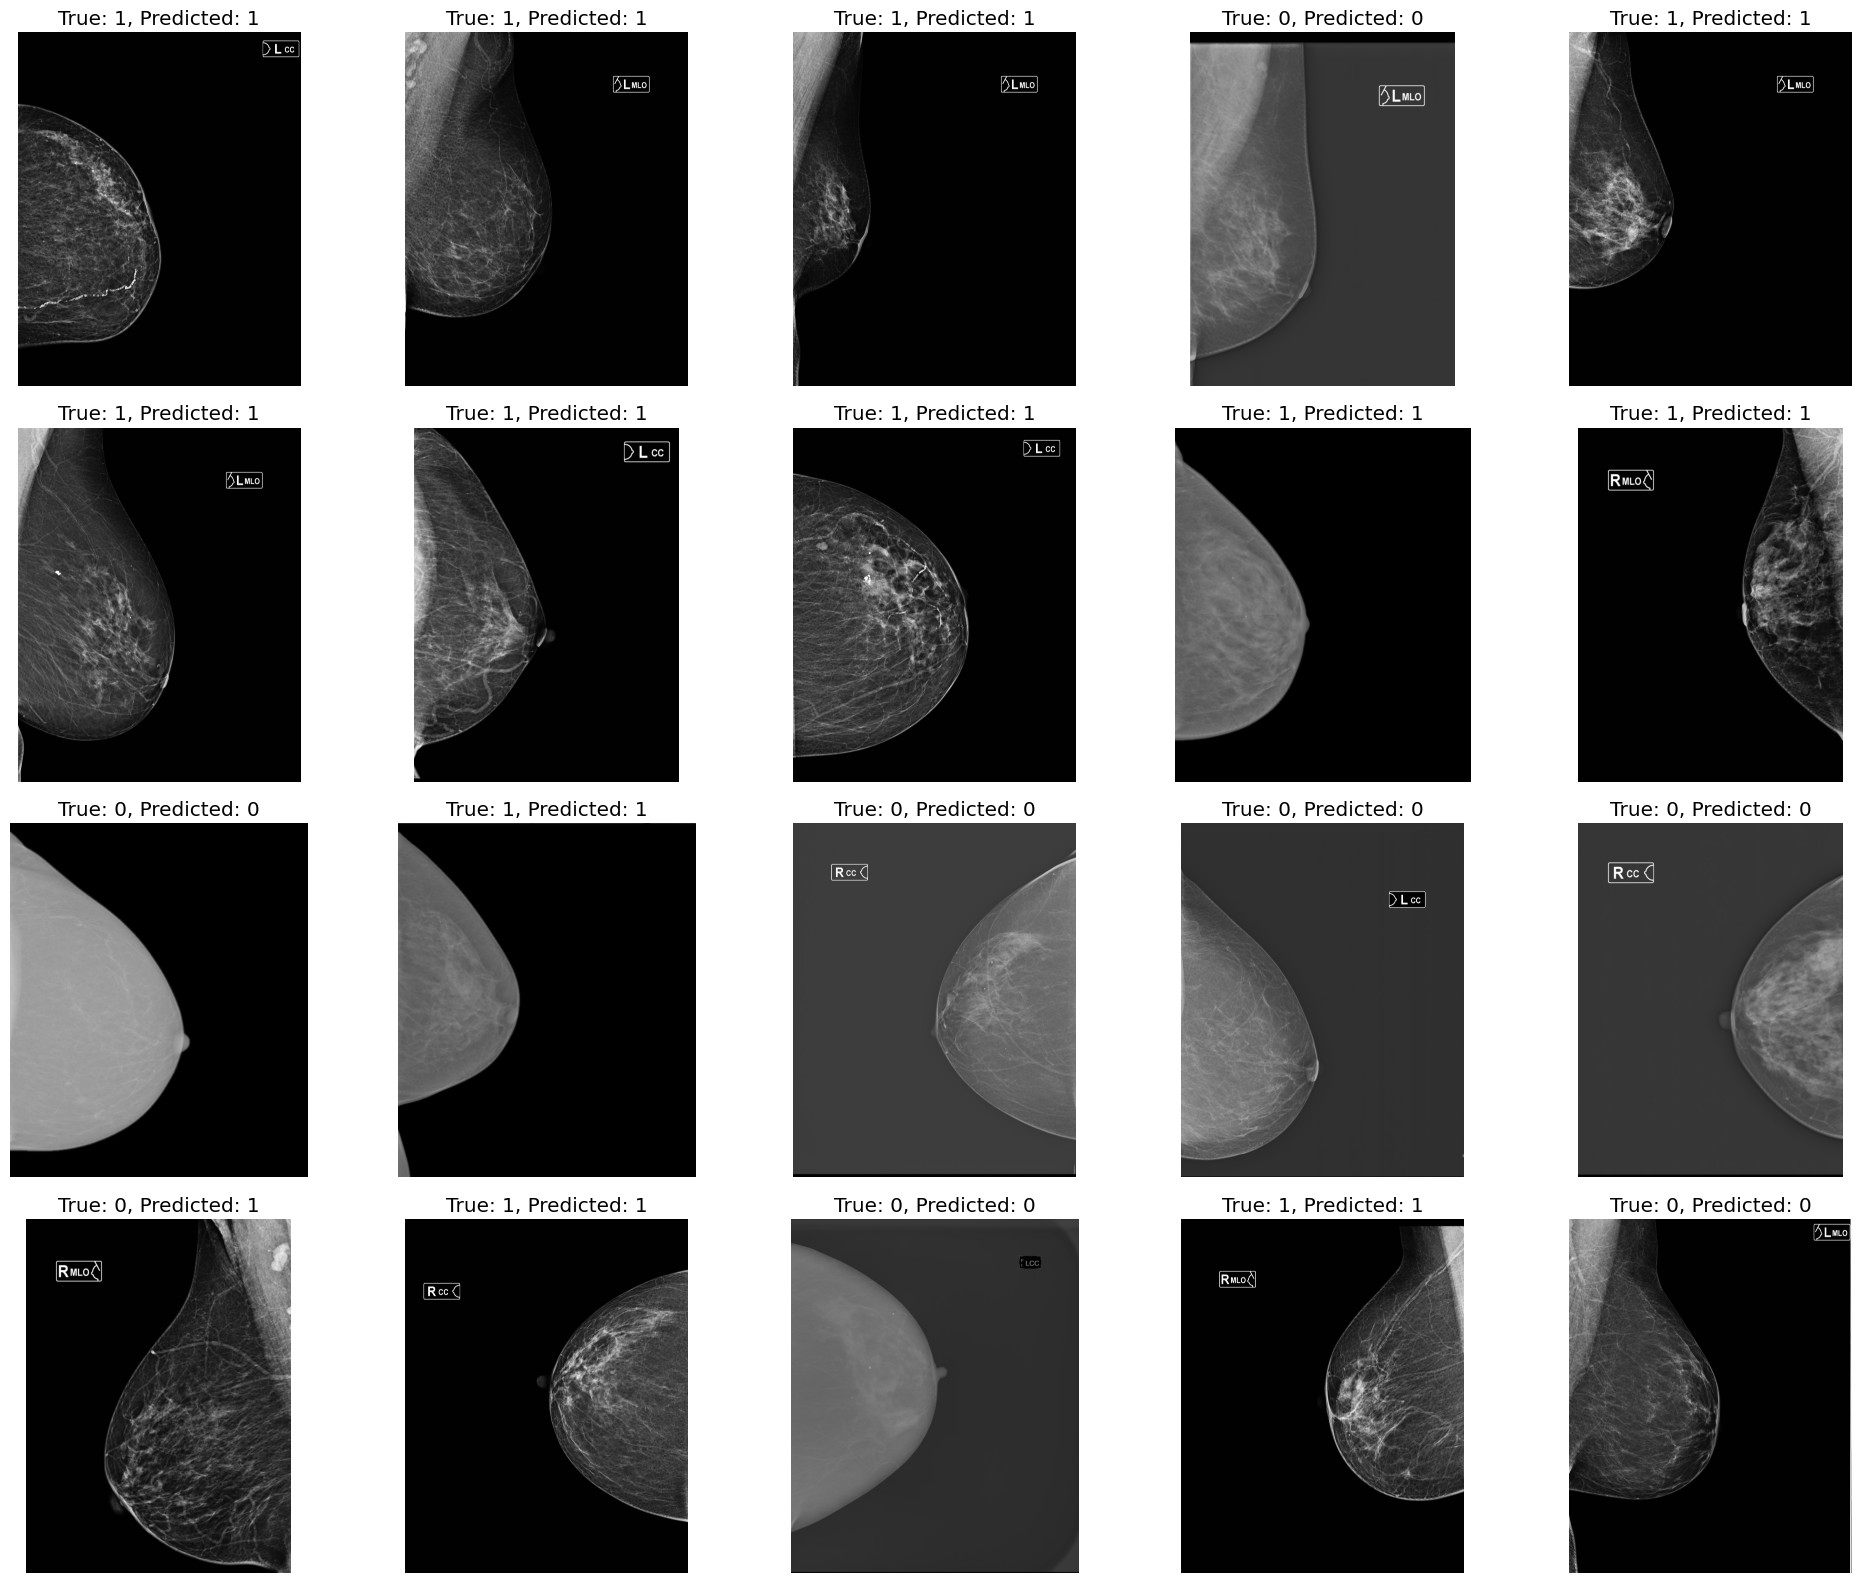

In [27]:
visualize_predictions(test_df, pred_labels, modelo)

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(targs, pred_labels)
precision = precision_score(targs, pred_labels, average='weighted')
recall = recall_score(targs, pred_labels, average='weighted')
f1 = f1_score(targs, pred_labels, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9504
Precision: 0.9550
Recall: 0.9504
F1 Score: 0.9504


In [28]:
bac_negativa_path = 'Images_JPEG_nuevos/DXm.1.2.840.113681.2207421036.704.3593662844.3397.1.jpeg'
bac_positiva_path = 'Images_JPEG_nuevos/DXm.1.2.392.200036.9125.4.0.656626344.956488136.148003828.jpeg'

In [29]:
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('L')
    img = np.array(img)
    img = np.stack([img, img, img], axis=0)
    img = np.transpose(img, (1, 2, 0))
    img = PILImage.create(img)
    return img

In [30]:
image = load_and_preprocess_image(bac_positiva_path)

In [31]:
pred, pred_idx, probs = modelo.predict(image)


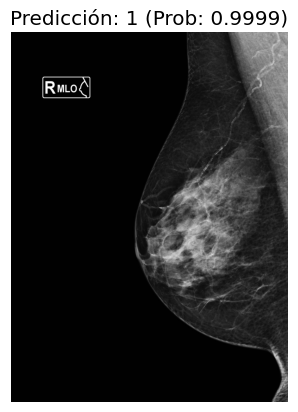

In [32]:
plt.imshow(image, cmap='gray')
plt.title(f'Predicción: {modelo.dls.vocab[pred_idx]} (Prob: {probs[pred_idx]:.4f})')
plt.axis('off')
plt.show()

In [ ]:
precision = precision_score(targs, pred_labels, average='weighted')
recall = recall_score(targs, pred_labels, average='weighted')
f1 = f1_score(targs, pred_labels, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')